# Track/Segment Person with SiamMask

This notebook uses an open source project [SiamMask](https://github.com/foolwood/SiamMask) to track and to segment a single person on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install SiamMask

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/foolwood/SiamMask.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !sed -i "/torch/d" {project_name}/requirements.txt
  !cd {project_name} && pip install -q -r requirements.txt
  !cd {project_name} && bash make.sh
  !pip install -q youtube-dl
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'experiments', 'siammask_sharp'))
import time
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

import cv2
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

from types import SimpleNamespace
from custom import Custom
from tools.test import *

## Download pretrained weights and initialize SiamMask 

In [0]:
exp_path = join(project_name, 'experiments/siammask_sharp')
pretrained_path1 = join(exp_path, 'SiamMask_DAVIS.pth')
pretrained_path2 = join(exp_path, 'SiamMask_VOT.pth')

# download pretrained weights
if not exists(pretrained_path1):
  !cd {exp_path} && wget http://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth
if not exists(pretrained_path2):
  !cd {exp_path} && wget http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth
    
# init SiamMask
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = load_config(SimpleNamespace(config=join(exp_path, 'config_davis.json')))
siammask = Custom(anchors=cfg['anchors'])
siammask = load_pretrain(siammask, pretrained_path1)
siammask = siammask.eval().to(device)

## Track a person on a test video with SiamMask

We are going to detect and track/segment a person on the following youtube video:

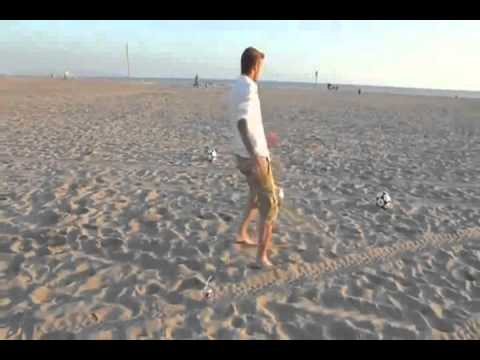

In [3]:
YOUTUBE_ID = 'c_6-8kvLFCs'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video and detect/track/segment a single person on the first 100 frames:

In [0]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4][vcodec!*=av01]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v={YOUTUBE_ID}

f = 0
video_capture = cv2.VideoCapture()
if video_capture.open('youtube.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break

    if f == 0:
      # detect a person on the first frame with Mask R-CNN
      maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
      maskrcnn = maskrcnn.eval()
      output = maskrcnn([torchvision.transforms.functional.to_tensor((frame[...,::-1] / 255).astype(np.float32))])[0]

      target_pos, target_sz = None, None
      for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        # search for a person with atleast 70% probability
        if score > 0.7 and label == 1:
          box = box.numpy()
          x, y = int(box[0]), int(box[1])
          w, h = int(box[2]) - x, int(box[3]) - y
          target_pos = np.array([x + w / 2, y + h / 2])
          target_sz = np.array([w, h])
          break
      assert target_pos is not None, "no person found on the first frame!"
      print("person found:", target_pos, target_sz)
      
      # init tracker
      state = siamese_init(frame, target_pos, target_sz, siammask, cfg['hp'], device=device)
    else:
      # track
      state = siamese_track(state, frame, mask_enable=True, refine_enable=True, device=device)
      location = state['ploygon'].flatten()
      mask = state['mask'] > state['p'].seg_thr
      
      frame[:, :, 2] = (mask > 0) * 255 + (mask == 0) * frame[:, :, 2]
      cv2.polylines(frame, [np.int0(location).reshape((-1, 1, 2))], True, (0, 255, 0), 3)
      
      video_writer.write(frame)
  
    f += 1
    # only on first 100 frames
    if f > 100:
      break
      
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

Finally, visualize the result:

In [0]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)